In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from patsy import dmatrices
import warnings

#import threading
#import multiprocessing

warnings.filterwarnings("ignore")
%matplotlib inline
sns.set_style('whitegrid')

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score

from pylab import rcParams
from sklearn import preprocessing

In [3]:
#titanic = pd.read_csv('https://raw.githubusercontent.com/bigdatagal/python-for-data-science/master/titanic-train.csv')
titanic = pd.read_csv('titanic_train.csv')
#titanic_test = pd.read_csv('titanic_test.csv')

In [4]:
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [5]:
del titanic['PassengerId']
#del titanic_test['PassengerId']

In [6]:
titanic.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [7]:
X = titanic.drop('Survived', axis=1)

In [8]:
y = titanic['Survived']

In [9]:
X= pd.get_dummies(X, columns=['Sex'], drop_first=True)

In [10]:
X.head()

,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_male
0,3,"Braund, Mr. Owen Harris",22.0,1,0,A/5 21171,7.2500,NaN,S,1
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,PC 17599,71.2833,C85,C,0
2,3,"Heikkinen, Miss. Laina",26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,0
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,113803,53.1000,C123,S,0
4,3,"Allen, Mr. William Henry",35.0,0,0,373450,8.0500,NaN,S,1


In [11]:
X.isna().mean()
# Age has ~20% null records

Pclass      0.000000
Name        0.000000
Age         0.198653
SibSp       0.000000
Parch       0.000000
Ticket      0.000000
Fare        0.000000
Cabin       0.771044
Embarked    0.002245
Sex_male    0.000000
dtype: float64

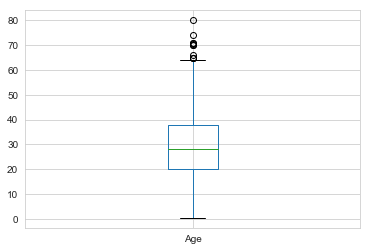

In [12]:
X.Age.plot(kind='box')
# Age had few outliers towards upper side

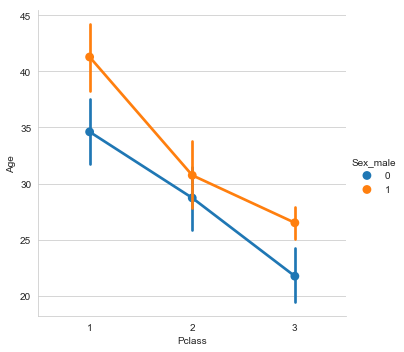

In [13]:
sns.factorplot('Pclass','Age',hue='Sex_male',data=X)

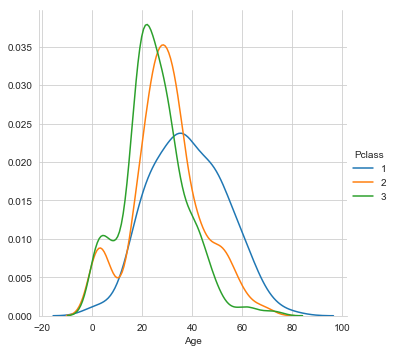

In [14]:
sns.FacetGrid(X, hue='Pclass', size=5).map(sns.kdeplot, "Age").add_legend()
# close to normal distribution

In [15]:
X[X.Age.isna()].groupby(['Pclass','Sex_male']).count()

Name  Age  SibSp  Parch  Ticket  Fare  Cabin  Embarked
Pclass Sex_male                                                        
1      0            9    0      9      9       9     9      5         9
       1           21    0     21     21      21    21     11        21
2      0            2    0      2      2       2     2      1         2
       1            9    0      9      9       9     9      0         9
3      0           42    0     42     42      42    42      1        42
       1           94    0     94     94      94    94      1        94

In [16]:
X.groupby(['Pclass','Sex_male']).Age.mean()

Pclass  Sex_male
1       0           34.611765
        1           41.281386
2       0           28.722973
        1           30.740707
3       0           21.750000
        1           26.507589
Name: Age, dtype: float64

In [17]:
X.Name.str.split(expand=True, pat=',')[1].str.split(expand=True, pat='.')[0].value_counts()

 Mr              517
 Miss            182
 Mrs             125
 Master           40
 Dr                7
 Rev               6
 Col               2
 Mlle              2
 Major             2
 the Countess      1
 Jonkheer          1
 Mme               1
 Sir               1
 Ms                1
 Lady              1
 Capt              1
 Don               1
Name: 0, dtype: int64

In [18]:
X['Salutation']= X.Name.str.split(expand=True, pat=',')[1].str.split(expand=True, pat='.')[0].str.strip()

In [19]:
X.Salutation.unique()

array(['Mr', 'Mrs', 'Miss', 'Master', 'Don', 'Rev', 'Dr', 'Mme', 'Ms',
       'Major', 'Lady', 'Sir', 'Mlle', 'Col', 'Capt', 'the Countess',
       'Jonkheer'], dtype=object)

In [20]:
X.Salutation.replace(['Don','Rev','Dr','Mme','Ms','Major','Lady','Sir','Mlle','Col','Capt','the Countess','Jonkheer'],
                           ['Mr','Mr','Mr','Miss','Miss','Mr','Mrs','Mr','Miss','Mr','Mr','Mrs','Mr'], inplace=True)

In [21]:
X.Salutation.value_counts()

Mr        538
Miss      186
Mrs       127
Master     40
Name: Salutation, dtype: int64

In [22]:
Age_mean = X.groupby(['Pclass','Sex_male','Salutation']).Age.mean().to_frame().reset_index()

In [23]:
Age_mean

,Pclass,Sex_male,Salutation,Age
0,1,0,Miss,29.625000
1,1,0,Mr,49.000000
2,1,0,Mrs,40.861111
3,1,1,Master,5.306667
4,1,1,Mr,42.382653
5,2,0,Miss,22.560606
6,2,0,Mrs,33.682927
7,2,1,Master,2.258889
8,2,1,Mr,33.588889
9,3,0,Miss,16.123188


In [24]:
# One record updated wrongly. One female doctor is also there
X[(X.Sex_male ==0) & (X.Salutation == 'Mr')]

,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_male,Salutation
796,1,"Leader, Dr. Alice (Farnham)",49.0,0,0,17465,25.9292,D17,S,0,Mr


In [25]:
X['Salutation'][(X.Sex_male ==0) & (X.Salutation == 'Mr')]='Mrs'

In [26]:
def replaceAge(row):
    row['Age'] = np.round(Age_mean[(Age_mean['Pclass']==row['Pclass']) & (Age_mean['Sex_male']==row['Sex_male']) & (Age_mean['Salutation']==row['Salutation'])]['Age'].values[0], 2)
    #print(row['Age']) 
    return row

In [27]:
X[X['Age'].isna()] = X[X['Age'].isna()].apply(replaceAge, axis=1)

In [28]:
X.isna().mean()
# no more missing values for Age

Pclass        0.000000
Name          0.000000
Age           0.000000
SibSp         0.000000
Parch         0.000000
Ticket        0.000000
Fare          0.000000
Cabin         0.771044
Embarked      0.002245
Sex_male      0.000000
Salutation    0.000000
dtype: float64

In [29]:
X.describe()

,Pclass,Age,SibSp,Parch,Fare,Sex_male
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,2.308642,29.448844,0.523008,0.381594,32.204208,0.647587
std,0.836071,13.561619,1.102743,0.806057,49.693429,0.477990
min,1.000000,0.420000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,21.000000,0.000000,0.000000,7.910400,0.000000
50%,3.000000,28.720000,0.000000,0.000000,14.454200,1.000000
75%,3.000000,36.750000,1.000000,0.000000,31.000000,1.000000
max,3.000000,80.000000,8.000000,6.000000,512.329200,1.000000


In [30]:
X.Age = pd.qcut(X.Age, 5, labels=[0,1,2,3,4])

In [31]:
X.head()

,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Sex_male,Salutation
0,3,"Braund, Mr. Owen Harris",1,1,0,A/5 21171,7.2500,NaN,S,1,Mr
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",3,1,0,PC 17599,71.2833,C85,C,0,Mrs
2,3,"Heikkinen, Miss. Laina",1,0,0,STON/O2. 3101282,7.9250,NaN,S,0,Miss
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",3,1,0,113803,53.1000,C123,S,0,Mrs
4,3,"Allen, Mr. William Henry",3,0,0,373450,8.0500,NaN,S,1,Mr


In [32]:
X_train, X_test, y_train, y_test = train_test_split(X.drop(['Name','Ticket','Fare','Cabin','Embarked','Salutation'], axis=1),y, test_size=0.3, random_state=123)

In [33]:
X_test.head()

,Pclass,Age,SibSp,Parch,Sex_male
172,3,0,1,1,0
524,3,2,0,0,1
452,1,2,0,0,1
170,1,4,0,0,1
620,3,2,1,0,1


In [34]:
from sklearn.tree import DecisionTreeClassifier 

In [35]:
dt = DecisionTreeClassifier( 
            criterion = "entropy", random_state = 100, 
            max_depth = 6, min_samples_leaf = 3)  

In [36]:
# Performing training 
dt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=6,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best')

In [37]:
y_pred = dt.predict(X_test)

In [38]:
metrics.accuracy_score(y_test, y_pred)

0.832089552238806

In [39]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.91      0.87       170
           1       0.82      0.69      0.75        98

   micro avg       0.83      0.83      0.83       268
   macro avg       0.83      0.80      0.81       268
weighted avg       0.83      0.83      0.83       268



In [40]:
dt1 = DecisionTreeClassifier( 
            criterion = "gini", random_state = 100, 
            max_depth = 8, min_samples_leaf = 3)  

In [41]:
dt1.fit(X_test, y_test)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=3, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=100,
            splitter='best')

In [42]:
y_pred = dt1.predict(X_test)

In [43]:
metrics.accuracy_score(y_test, y_pred)

0.8582089552238806

In [44]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.95      0.90       170
           1       0.89      0.69      0.78        98

   micro avg       0.86      0.86      0.86       268
   macro avg       0.87      0.82      0.84       268
weighted avg       0.86      0.86      0.85       268

